In [ ]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [1]:
! python --version

Python 3.8.20


In [2]:
! pip install POT

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
! pip install --no-cache-dir --force-reinstall scikit-misc

In [7]:
! pip install GraphST

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
!conda info --envs


# conda environments:
#
base                   D:\Anaconda
GraphSTenv           * D:\Anaconda\envs\GraphSTenv
myenv                  D:\Anaconda\envs\myenv



In [2]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [3]:
import torch
import numpy as np
import scanpy as sc
import anndata
import rpy2
import pandas as pd
import scipy
import sklearn
import tqdm
import matplotlib

print("PyTorch version:", torch.__version__)
print(torch.__file__)
print("NumPy version:", np.__version__)
print("Scanpy version:", sc.__version__)
print("AnnData version:", anndata.__version__)
print("rpy2 version:", rpy2.__version__)
print("Pandas version:", pd.__version__)
print("SciPy version:", scipy.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TQDM version:", tqdm.__version__)
print("Matplotlib version:", matplotlib.__version__)


PyTorch version: 2.4.1+cu121
d:\Anaconda\envs\GraphSTenv\lib\site-packages\torch\__init__.py
NumPy version: 1.24.4
Scanpy version: 1.9.1
AnnData version: 0.8.0
rpy2 version: 3.4.1
Pandas version: 1.4.2
SciPy version: 1.8.1
Scikit-learn version: 1.1.1
TQDM version: 4.64.0
Matplotlib version: 3.4.2


In [4]:
from GraphST import GraphST

In [5]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

CUDA available: True
CUDA device count: 1


In [6]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'D:/R/R-4.3.3'

In [8]:
# the number of clusters
n_clusters = 7

# 151673

In [10]:
dataset = '151673'

In [11]:
file_fold = './151673'  # 使用相对路径
adata = sc.read_visium(file_fold, count_file='expression_matrix.h5', load_images=True)
adata.var_names_make_unique()

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
adata

AnnData object with n_obs × n_vars = 4992 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
spatial = pd.read_csv(file_fold + '/spatial/tissue_positions_list.csv', sep=",", header=None, na_filter=False, index_col=0)
print("Spatial coordinates shape:", spatial.shape)
print("First few rows of spatial coordinates:")
print(spatial.head())

Spatial coordinates shape: (4992, 5)
First few rows of spatial coordinates:
                    1  2  3     4     5
0                                      
ACGCCTGACACGCGCT-1  0  0  0  2427  2811
TACCGATCCAACACTT-1  0  1  1  2547  2879
ATTAAAGCGGACGAGC-1  0  0  2  2428  2949
GATAAGGGACGATTAG-1  0  1  3  2548  3017
GTGCAAATCACCAATA-1  0  0  4  2429  3086


In [14]:
# 确保坐标列正确赋值
adata.obs["x1"] = spatial[1]
adata.obs["x2"] = spatial[2]
adata.obs["x3"] = spatial[3]
adata.obs["x4"] = spatial[4]
adata.obs["x5"] = spatial[5]

# 打印坐标范围
print("\nCoordinate ranges:")
print("x4 (x_pixel) range:", adata.obs["x4"].min(), adata.obs["x4"].max())
print("x5 (y_pixel) range:", adata.obs["x5"].min(), adata.obs["x5"].max())

# 使用正确的像素坐标列
adata.obs["x_pixel"] = adata.obs["x4"]  # 使用x4作为x坐标（实际像素坐标）
adata.obs["y_pixel"] = adata.obs["x5"]  # 使用x5作为y坐标（实际像素坐标）
print("Spatial coordinates processed!")

# 添加预处理步骤，参考SpaGCN教程
print("Preprocessing data...")
sc.pp.normalize_per_cell(adata, min_counts=0)
sc.pp.log1p(adata)
print("Preprocessing completed!")


Coordinate ranges:
x4 (x_pixel) range: 2427 11715
x5 (y_pixel) range: 2745 11555
Spatial coordinates processed!
Preprocessing data...
Preprocessing completed!


In [15]:
model = GraphST.GraphST(adata, device=device)
adata = model.train()

d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [00:12<00:00, 46.17it/s]

Optimization finished for ST data!


In [16]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [17]:
df_meta = pd.read_csv(file_fold + '/151673_layer_annotations.csv')
print(f"Layer annotations shape: {df_meta.shape}")
print(f"AnnData shape: {adata.shape}")

Layer annotations shape: (3611, 2)
AnnData shape: (4992, 33538)


In [18]:
# 检查元数据和数据的索引
meta_index = df_meta['barcode'].tolist()
adata_index = adata.obs.index.tolist()

# 计算重叠部分
common_spots = set(meta_index).intersection(set(adata_index))
print(f"Common spots between layer annotations and data: {len(common_spots)}")

# 根据元数据索引筛选数据
if len(meta_index) != len(adata_index):
    print("Filtering data to match layer annotations...")
    adata = adata[adata.obs.index.isin(meta_index)]
    print(f"After filtering, AnnData shape: {adata.shape}")

# 确保元数据和数据索引完全对齐
df_meta = df_meta.set_index('barcode')
df_meta = df_meta.loc[adata.obs.index]

# 赋值地面真值
adata.obs['ground_truth'] = df_meta['layer'].values

# 过滤掉NA节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
print(f"After filtering NA, AnnData shape: {adata.shape}")

# 计算指标ARI和NMI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
adata.uns['NMI'] = NMI

print('Dataset:', dataset)
print('ARI:', ARI)
print('NMI:', NMI)

Common spots between layer annotations and data: 3611
Filtering data to match layer annotations...
After filtering, AnnData shape: (3611, 33538)


C:\Users\hyl01\AppData\Local\Temp\ipykernel_24944\3202292389.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ground_truth'] = df_meta['layer'].values


After filtering NA, AnnData shape: (3611, 33538)


d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.1275995617320699
NMI: 0.3814670313033818


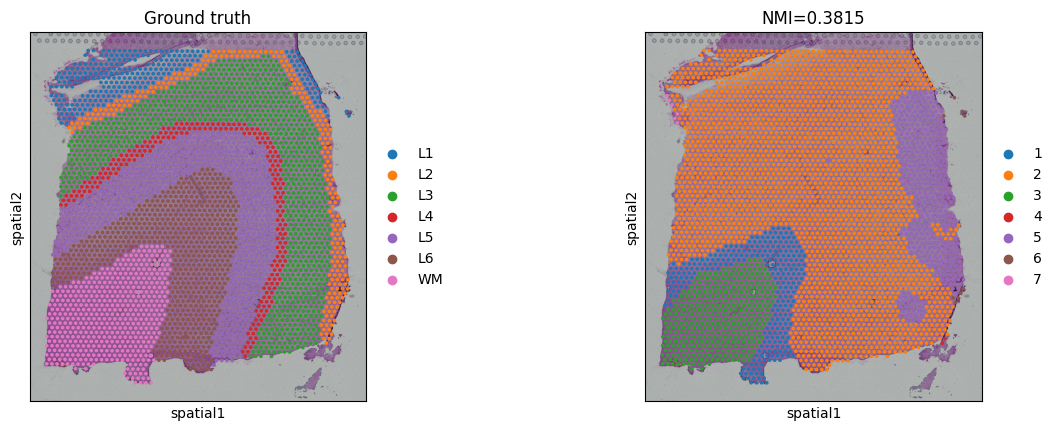

In [22]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "NMI=%.4f"%NMI],
              show=True)

d:\Anaconda\envs\GraphSTenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

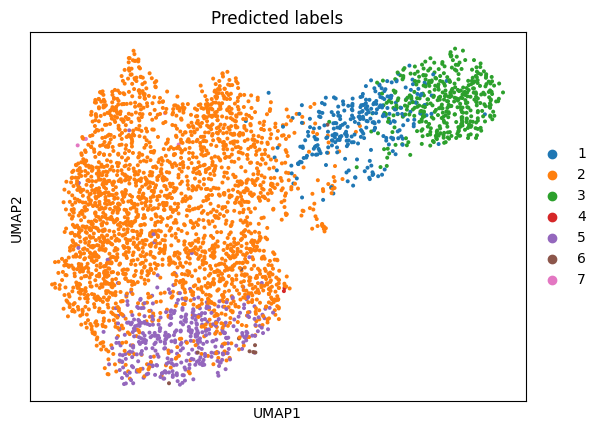

In [23]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

# 151508

In [9]:
# the number of clusters
n_clusters = 7

In [15]:
dataset = '151508'
file_fold = './151508'  # 使用相对路径
adata = sc.read_visium(file_fold, count_file='151508_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
adata

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [16]:
spatial = pd.read_csv(file_fold + '/spatial/tissue_positions_list.csv', sep=",", header=None, na_filter=False, index_col=0)
print("Spatial coordinates shape:", spatial.shape)
print("First few rows of spatial coordinates:")
print(spatial.head())

Spatial coordinates shape: (4992, 5)
First few rows of spatial coordinates:
                    1  2  3     4     5
0                                      
ACGCCTGACACGCGCT-1  0  0  0  2575  2169
TACCGATCCAACACTT-1  0  1  1  2695  2237
ATTAAAGCGGACGAGC-1  0  0  2  2576  2306
GATAAGGGACGATTAG-1  0  1  3  2696  2375
GTGCAAATCACCAATA-1  0  0  4  2576  2444


In [17]:
# 确保坐标列正确赋值
adata.obs["x1"] = spatial[1]
adata.obs["x2"] = spatial[2]
adata.obs["x3"] = spatial[3]
adata.obs["x4"] = spatial[4]
adata.obs["x5"] = spatial[5]

# 打印坐标范围
print("\nCoordinate ranges:")
print("x4 (x_pixel) range:", adata.obs["x4"].min(), adata.obs["x4"].max())
print("x5 (y_pixel) range:", adata.obs["x5"].min(), adata.obs["x5"].max())

# 使用正确的像素坐标列
adata.obs["x_pixel"] = adata.obs["x4"]  # 使用x4作为x坐标（实际像素坐标）
adata.obs["y_pixel"] = adata.obs["x5"]  # 使用x5作为y坐标（实际像素坐标）
print("Spatial coordinates processed!")

# 添加预处理步骤，参考SpaGCN教程
print("Preprocessing data...")
sc.pp.normalize_per_cell(adata, min_counts=0)
sc.pp.log1p(adata)
print("Preprocessing completed!")


Coordinate ranges:
x4 (x_pixel) range: 2579 11821
x5 (y_pixel) range: 2152 10910
Spatial coordinates processed!
Preprocessing data...
Preprocessing completed!


In [18]:
model = GraphST.GraphST(adata, device=device)
adata = model.train()

d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [00:10<00:00, 55.26it/s]

Optimization finished for ST data!


In [19]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [20]:
df_meta = pd.read_csv(file_fold + '/151508_layer_annotations.csv')
print(f"Layer annotations shape: {df_meta.shape}")
print(f"AnnData shape: {adata.shape}")

Layer annotations shape: (4381, 2)
AnnData shape: (4384, 33538)


In [21]:
# 检查元数据和数据的索引
meta_index = df_meta['barcode'].tolist()
adata_index = adata.obs.index.tolist()

# 计算重叠部分
common_spots = set(meta_index).intersection(set(adata_index))
print(f"Common spots between layer annotations and data: {len(common_spots)}")

# 根据元数据索引筛选数据
if len(meta_index) != len(adata_index):
    print("Filtering data to match layer annotations...")
    adata = adata[adata.obs.index.isin(meta_index)]
    print(f"After filtering, AnnData shape: {adata.shape}")

# 确保元数据和数据索引完全对齐
df_meta = df_meta.set_index('barcode')
df_meta = df_meta.loc[adata.obs.index]

# 赋值地面真值
adata.obs['ground_truth'] = df_meta['layer'].values

# 过滤掉NA节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
print(f"After filtering NA, AnnData shape: {adata.shape}")

# 计算指标ARI和NMI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
adata.uns['NMI'] = NMI

print('Dataset:', dataset)
print('ARI:', ARI)
print('NMI:', NMI)

Common spots between layer annotations and data: 4381
Filtering data to match layer annotations...
After filtering, AnnData shape: (4381, 33538)


C:\Users\hyl01\AppData\Local\Temp\ipykernel_26272\3202292389.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ground_truth'] = df_meta['layer'].values


After filtering NA, AnnData shape: (4381, 33538)


d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151508
ARI: 0.31930330029457554
NMI: 0.5004750429048079


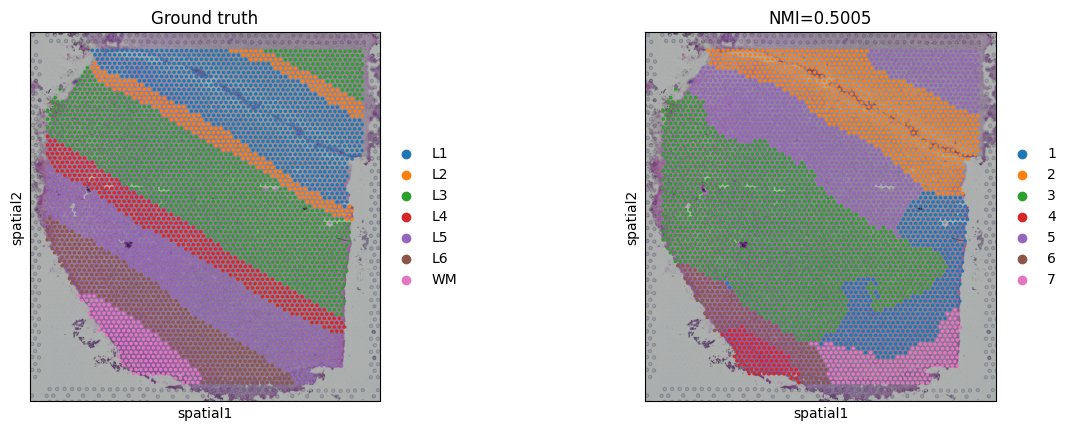

In [22]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "NMI=%.4f"%NMI],
              show=True)

d:\Anaconda\envs\GraphSTenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

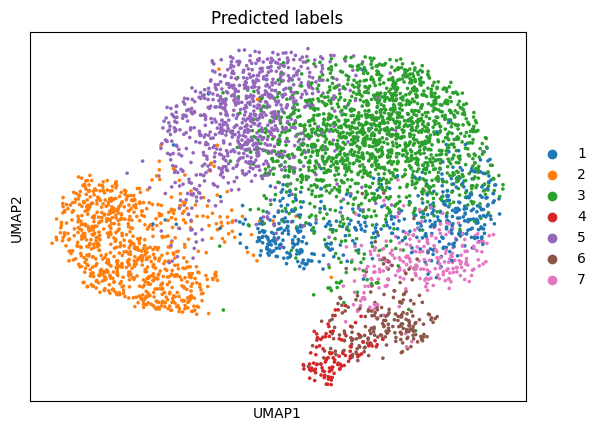

In [23]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

# 151510

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Spatial coordinates shape: (4992, 5)
First few rows of spatial coordinates:
                    1  2  3     4     5
0                                      
ACGCCTGACACGCGCT-1  0  0  0  2629  2222
TACCGATCCAACACTT-1  0  1  1  2750  2290
ATTAAAGCGGACGAGC-1  0  0  2  2630  2360
GATAAGGGACGATTAG-1  0  1  3  2751  2429
GTGCAAATCACCAATA-1  0  0  4  2631  2499

Coordinate ranges:
x4 (x_pixel) range: 2649 11968
x5 (y_pixel) range: 2163 10999
Spatial coordinates processed!
Preprocessing data...
Preprocessing completed!


d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [00:11<00:00, 52.64it/s]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%
Layer annotations shape: (4595, 2)
AnnData shape: (4634, 33538)
Common spots between layer annotations and data: 4595
Filtering data to match layer annotations...
After filtering, AnnData shape: (4595, 33538)


C:\Users\hyl01\AppData\Local\Temp\ipykernel_26272\1242270725.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ground_truth'] = df_meta['layer'].values


After filtering NA, AnnData shape: (4595, 33538)


d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151510
ARI: 0.37629629989348207
NMI: 0.5636404028735742


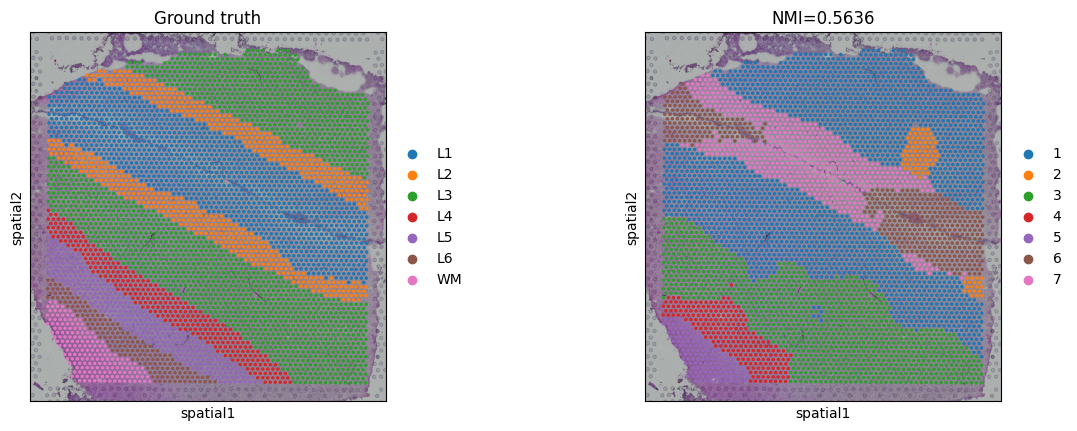

<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

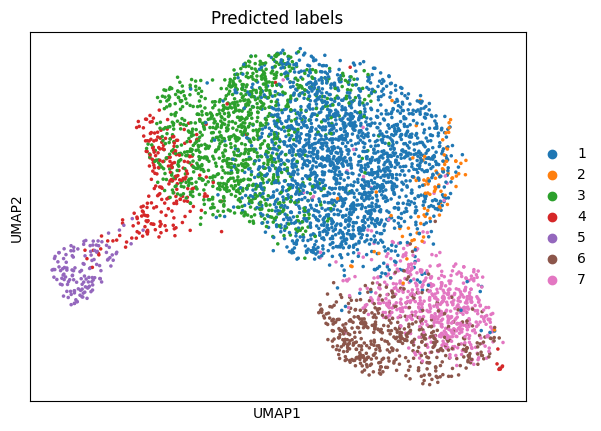

In [24]:
# the number of clusters
n_clusters = 7

dataset = '151510'
file_fold = './151510'  # 使用相对路径
adata = sc.read_visium(file_fold, count_file='151510_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
adata

spatial = pd.read_csv(file_fold + '/spatial/tissue_positions_list.csv', sep=",", header=None, na_filter=False, index_col=0)
print("Spatial coordinates shape:", spatial.shape)
print("First few rows of spatial coordinates:")
print(spatial.head())

# 确保坐标列正确赋值
adata.obs["x1"] = spatial[1]
adata.obs["x2"] = spatial[2]
adata.obs["x3"] = spatial[3]
adata.obs["x4"] = spatial[4]
adata.obs["x5"] = spatial[5]

# 打印坐标范围
print("\nCoordinate ranges:")
print("x4 (x_pixel) range:", adata.obs["x4"].min(), adata.obs["x4"].max())
print("x5 (y_pixel) range:", adata.obs["x5"].min(), adata.obs["x5"].max())

# 使用正确的像素坐标列
adata.obs["x_pixel"] = adata.obs["x4"]  # 使用x4作为x坐标（实际像素坐标）
adata.obs["y_pixel"] = adata.obs["x5"]  # 使用x5作为y坐标（实际像素坐标）
print("Spatial coordinates processed!")

# 添加预处理步骤，参考SpaGCN教程
print("Preprocessing data...")
sc.pp.normalize_per_cell(adata, min_counts=0)
sc.pp.log1p(adata)
print("Preprocessing completed!")

model = GraphST.GraphST(adata, device=device)
adata = model.train()

# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

df_meta = pd.read_csv(file_fold + '/151510_layer_annotations.csv')
print(f"Layer annotations shape: {df_meta.shape}")
print(f"AnnData shape: {adata.shape}")

# 检查元数据和数据的索引
meta_index = df_meta['barcode'].tolist()
adata_index = adata.obs.index.tolist()

# 计算重叠部分
common_spots = set(meta_index).intersection(set(adata_index))
print(f"Common spots between layer annotations and data: {len(common_spots)}")

# 根据元数据索引筛选数据
if len(meta_index) != len(adata_index):
    print("Filtering data to match layer annotations...")
    adata = adata[adata.obs.index.isin(meta_index)]
    print(f"After filtering, AnnData shape: {adata.shape}")

# 确保元数据和数据索引完全对齐
df_meta = df_meta.set_index('barcode')
df_meta = df_meta.loc[adata.obs.index]

# 赋值地面真值
adata.obs['ground_truth'] = df_meta['layer'].values

# 过滤掉NA节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
print(f"After filtering NA, AnnData shape: {adata.shape}")

# 计算指标ARI和NMI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
adata.uns['NMI'] = NMI

print('Dataset:', dataset)
print('ARI:', ARI)
print('NMI:', NMI)

# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "NMI=%.4f"%NMI],
              show=True)

# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

# 151674

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Spatial coordinates shape: (4992, 5)
First few rows of spatial coordinates:
                    1  2  3     4     5
0                                      
ACGCCTGACACGCGCT-1  0  0  0  2492  2756
TACCGATCCAACACTT-1  0  1  1  2612  2824
ATTAAAGCGGACGAGC-1  0  0  2  2493  2894
GATAAGGGACGATTAG-1  0  1  3  2613  2962
GTGCAAATCACCAATA-1  0  0  4  2494  3031

Coordinate ranges:
x4 (x_pixel) range: 2505 11769
x5 (y_pixel) range: 2967 10934
Spatial coordinates processed!
Preprocessing data...
Preprocessing completed!


d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [00:08<00:00, 73.48it/s]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%
Layer annotations shape: (3635, 2)
AnnData shape: (3673, 33538)
Common spots between layer annotations and data: 3635
Filtering data to match layer annotations...
After filtering, AnnData shape: (3635, 33538)
After filtering NA, AnnData shape: (3635, 33538)


C:\Users\hyl01\AppData\Local\Temp\ipykernel_26272\883416490.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ground_truth'] = df_meta['layer'].values
d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151674
ARI: 0.32979783878346763
NMI: 0.478741375402665


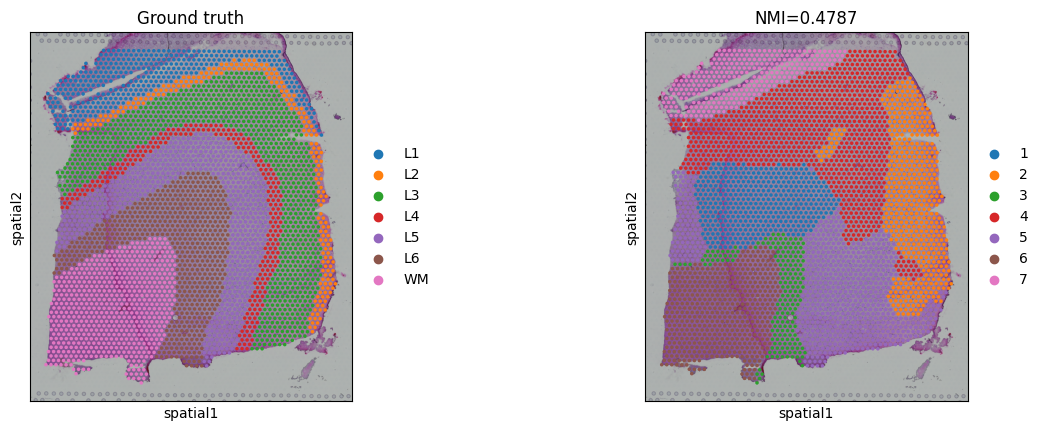

<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

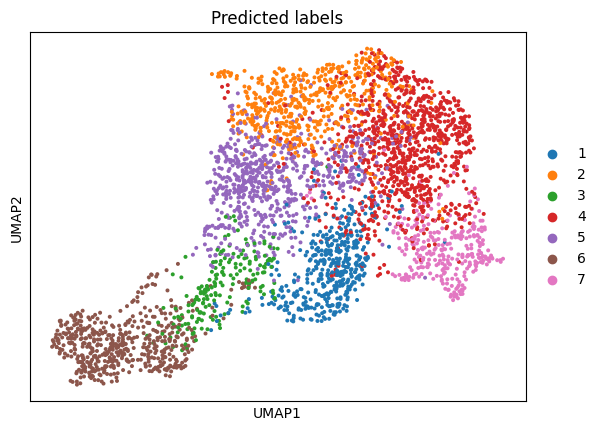

In [25]:
# the number of clusters
n_clusters = 7

dataset = '151674'
file_fold = './151674'  # 使用相对路径
adata = sc.read_visium(file_fold, count_file='151674_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
adata

spatial = pd.read_csv(file_fold + '/spatial/tissue_positions_list.csv', sep=",", header=None, na_filter=False, index_col=0)
print("Spatial coordinates shape:", spatial.shape)
print("First few rows of spatial coordinates:")
print(spatial.head())

# 确保坐标列正确赋值
adata.obs["x1"] = spatial[1]
adata.obs["x2"] = spatial[2]
adata.obs["x3"] = spatial[3]
adata.obs["x4"] = spatial[4]
adata.obs["x5"] = spatial[5]

# 打印坐标范围
print("\nCoordinate ranges:")
print("x4 (x_pixel) range:", adata.obs["x4"].min(), adata.obs["x4"].max())
print("x5 (y_pixel) range:", adata.obs["x5"].min(), adata.obs["x5"].max())

# 使用正确的像素坐标列
adata.obs["x_pixel"] = adata.obs["x4"]  # 使用x4作为x坐标（实际像素坐标）
adata.obs["y_pixel"] = adata.obs["x5"]  # 使用x5作为y坐标（实际像素坐标）
print("Spatial coordinates processed!")

# 添加预处理步骤，参考SpaGCN教程
print("Preprocessing data...")
sc.pp.normalize_per_cell(adata, min_counts=0)
sc.pp.log1p(adata)
print("Preprocessing completed!")

model = GraphST.GraphST(adata, device=device)
adata = model.train()

# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

df_meta = pd.read_csv(file_fold + '/151674_layer_annotations.csv')
print(f"Layer annotations shape: {df_meta.shape}")
print(f"AnnData shape: {adata.shape}")

# 检查元数据和数据的索引
meta_index = df_meta['barcode'].tolist()
adata_index = adata.obs.index.tolist()

# 计算重叠部分
common_spots = set(meta_index).intersection(set(adata_index))
print(f"Common spots between layer annotations and data: {len(common_spots)}")

# 根据元数据索引筛选数据
if len(meta_index) != len(adata_index):
    print("Filtering data to match layer annotations...")
    adata = adata[adata.obs.index.isin(meta_index)]
    print(f"After filtering, AnnData shape: {adata.shape}")

# 确保元数据和数据索引完全对齐
df_meta = df_meta.set_index('barcode')
df_meta = df_meta.loc[adata.obs.index]

# 赋值地面真值
adata.obs['ground_truth'] = df_meta['layer'].values

# 过滤掉NA节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
print(f"After filtering NA, AnnData shape: {adata.shape}")

# 计算指标ARI和NMI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
adata.uns['NMI'] = NMI

print('Dataset:', dataset)
print('ARI:', ARI)
print('NMI:', NMI)

# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "NMI=%.4f"%NMI],
              show=True)

# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)